In [1]:
import os
import cv2
import zipfile
import joblib
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

#### config file

In [2]:
RAW_DATA_PATH = "../../data/raw/"
PROCESSED_DATA_PATH = "../../data/processed/"

#### Utils file

In [3]:
def dump(value, filename):
    if (value is not None) and (filename is not None):
        joblib.dump(value=value, filename=filename)
    else:
        raise Exception("Value or filename not provided")
    
def load(filename):
    if (filename is not None):
        return joblib.load(filename=filename)
    else:
        raise Exception("Filename not provided")
    
def weight_init(m, he_normal = False):
    classname = m.__class__.__name__
    
    if classname.find("Conv") != -1:
        if he_normal:
            nn.init.kaiming_normal_(
                m.weight, mode="fan_out", nonlinearity="relu")
        else:
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            
    elif classname.find("BatchNorm")!= -1:
        if he_normal:
            nn.init.kaiming_normal_(
                m.weight, mode="fan_out", nonlinearity="relu")        
        else:
            nn.init.normal_(m.weight, mean=1.0, std=0.02)
            nn.init.constant_(m.bias, 0.0)
            
            
def device_init(device = "mps"):
    if device == "mps":
        return torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    elif device == "cuda":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        return torch.device("cpu")

#### Dataloader

Train images: 5712
Test images: 1311
Train: lower resolution images shape: torch.size([3, 64, 64])
Train: higher resolution images shape: torch.size([3, 256, 256])
Test: lower resolution images shape: torch.size([64, 3, 64, 64])
Test: higher resolution images shape: torch.size([64, 3, 256, 256])


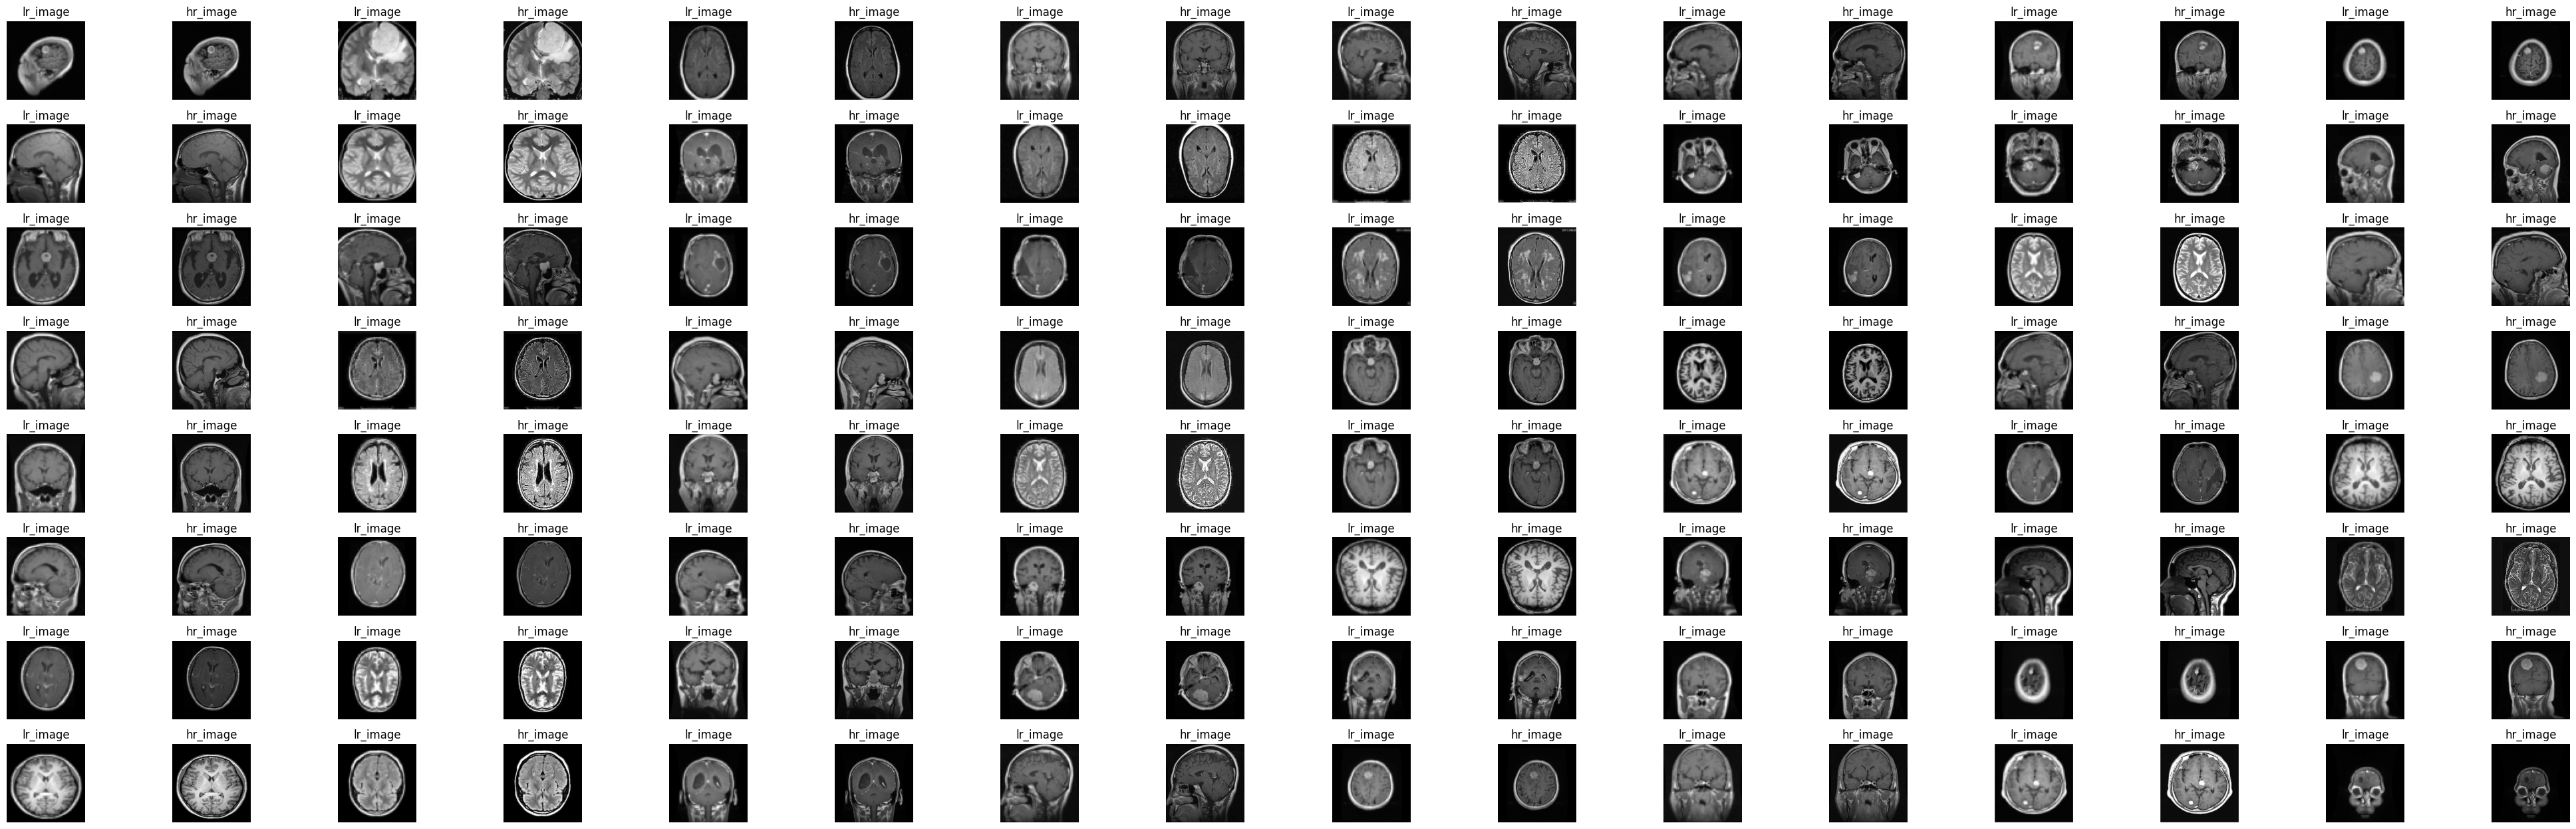

In [4]:
class Loader(Dataset):
    def __init__(self, image_path = None, in_channels = 3, batch_size = 1, image_size = 64):
        self.image_path = image_path
        self.batch_size = batch_size
        self.in_channels = in_channels
        self.image_size = image_size

        self.train_images = list()
        self.train_labels = list()
        self.test_images = list()
        self.test_labels = list()

    def image_normalized(self, lr_images=True):
        return transforms.Compose(
            [
                (
                    transforms.Resize((self.image_size, self.image_size))
                    if lr_images
                    else transforms.Resize((self.image_size*4, self.image_size*4))
                ),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )

    def unzip_folder(self):
        if os.path.exists(RAW_DATA_PATH):
            with zipfile.ZipFile(self.image_path, "r") as zip_file:
                zip_file.extractall(os.path.join(RAW_DATA_PATH, "images"))
        else:
            raise Exception("Raw data folder not found".capitalize())

    def extract_images(self):
        if os.path.exists(RAW_DATA_PATH):
            image_path = os.path.join(RAW_DATA_PATH, "images")

            train_images = os.path.join(image_path, os.listdir(image_path)[0])
            test_images = os.path.join(image_path, os.listdir(image_path)[1])

            for idx, path in enumerate([train_images, test_images]):
                categories = os.listdir(path)

                for category in categories:
                    images = os.path.join(path, category)

                    for image in os.listdir(images):
                        self.image_path = os.path.join(images, image)
                        self.image = cv2.imread(self.image_path)

                        if self.image is not None:
                            if idx == 0:
                                self.train_images.append(
                                    self.image_normalized(lr_images=True)(
                                        Image.fromarray(self.image)
                                    )
                                )

                                self.train_labels.append(
                                    self.image_normalized(lr_images=False)(
                                        Image.fromarray(self.image)
                                    )
                                )
                            else:
                                self.test_images.append(
                                    self.image_normalized(lr_images=True)(
                                        Image.fromarray(self.image)
                                    )
                                )

                                self.test_labels.append(
                                    self.image_normalized(lr_images=False)(
                                        Image.fromarray(self.image)
                                    )
                                )
                        else:
                            continue
            return {
                "train_images": self.train_images,
                "train_labels": self.train_labels,
                "test_images": self.test_images,
                "test_labels": self.test_labels
                }
        else:
            raise Exception("Raw data folder not found".capitalize())

    def create_dataloader(self):
        try:
            images = self.extract_images()
        except Exception as e:
            print("Error in extracting images".capitalize())
        else:
            train_dataloader = DataLoader(
                dataset=list(zip(images["train_images"], images["train_labels"])), batch_size=self.batch_size, shuffle=True)
            test_dataloader = DataLoader(
                dataset=list(zip(images["test_images"], images["test_labels"])), batch_size=self.batch_size*64, shuffle=True)

            if os.path.join(PROCESSED_DATA_PATH):
                try:
                    dump(
                        value=train_dataloader, filename=os.path.join(PROCESSED_DATA_PATH, "train_dataloader.pkl"))
                except Exception as e:
                    print("Error in dumping train dataloader".capitalize())

                try:   
                    dump(
                        value=test_dataloader, filename=os.path.join(PROCESSED_DATA_PATH, "test_dataloader.pkl"))
                except Exception as e:
                    print("Error in dumping test dataloader".capitalize())
            else:
                raise Exception("Processed data folder not found".capitalize())

    @staticmethod
    def display_images():
        if os.path.exists(PROCESSED_DATA_PATH):
            images = list()
            labels = list()

            train_images = load(filename=os.path.join(PROCESSED_DATA_PATH, "train_dataloader.pkl"))

            for index, (image, label) in enumerate(train_images):

                if index !=64:
                    images.append(image)
                    labels.append(label)
                else:
                    break

            plt.figure(figsize=(40, 25))

            for index, (lr_image, hr_image) in enumerate(zip(images, labels)):

                lr_image = lr_image.squeeze().permute(1, 2, 0)
                lr_image = lr_image.cpu().detach().numpy()
                lr_image = (lr_image - lr_image.min())/(lr_image.max() - lr_image.min())

                plt.subplot(2 * 8, 2 * 8, 2 * index + 1)
                plt.imshow(lr_image, cmap="gray")
                plt.title("lr_image".lower())
                plt.axis("off")

                hr_image = hr_image.squeeze().permute(1, 2, 0)
                hr_image = hr_image.cpu().detach().numpy()
                hr_image = (hr_image - hr_image.min())/(hr_image.max() - hr_image.min())

                plt.subplot(2 * 8, 2 * 8, 2 * index + 2)
                plt.imshow(hr_image, cmap="gray")
                plt.title("hr_image".lower())
                plt.axis("off")

            plt.tight_layout()
            plt.show()

    @staticmethod
    def details_dataset():
        if os.path.exists(PROCESSED_DATA_PATH):
            train_dataloader = load(filename=os.path.join(PROCESSED_DATA_PATH, "train_dataloader.pkl"))
            test_dataloader = load(filename=os.path.join(PROCESSED_DATA_PATH, "test_dataloader.pkl"))

            train = sum(data.size(0) for data, _ in train_dataloader)
            test = sum(data.size(0) for data, _ in test_dataloader)

            train_lr_images, train_hr_images = next(iter(train_dataloader))
            test_lr_images, test_hr_images = next(iter(test_dataloader))

            print("Train images: {}".format(train))
            print("Test images: {}".format(test))

            print(
                "Train: lower resolution images shape: {}".format(
                    train_lr_images.squeeze().size()
                ).capitalize()
            )
            print(
                "Train: higher resolution images shape: {}".format(
                    train_hr_images.squeeze().size()
                ).capitalize()
            )
            print(
                "Test: lower resolution images shape: {}".format(
                    test_lr_images.squeeze().size()
                ).capitalize()
            )
            print(
                "Test: higher resolution images shape: {}".format(
                    test_hr_images.squeeze().size()
                ).capitalize()
            )

        else:
            raise Exception("Processed data folder not found".capitalize())
        
        
        
if __name__ == "__main__":
    loader = Loader(image_path="/Users/shahmuhammadraditrahman/Desktop/brain.zip")
    loader.unzip_folder()
    loader.create_dataloader()
    
    loader.details_dataset()
    loader.display_images()

#### Generator

In [5]:
class InputBlock(nn.Module):
    def __init__(self, in_channels = None, out_channels = None):
        super(InputBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.kernel_size = 9
        self.stride = 1
        self.padding = 4
        
        try:
            self.model = self.input_block()
        except Exception as e:
            print("Input block not implemented")
        
    def input_block(self):
        layers = OrderedDict()
        
        layers["conv"] = nn.Conv2d(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            kernel_size = self.kernel_size,
            stride = self.stride,
            padding = self.padding
        )
        layers["PReLU"] = nn.PReLU()
        
        return nn.Sequential(layers)
    
    def forward(self, x=None):
        if x is not None:
            return self.model(x)
        else:
            raise Exception("Input block not implemented")

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels = None, out_channels = None, index = None):
        super(ResidualBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.index = index
        
        self.kernel_size = 3
        self.stride = 1
        self.padding = 1
        
        try:
            self.model = self.residual_block()
        except Exception as e:
            print("Residual block not implemented")
        
    def residual_block(self):
        layers = OrderedDict()
        
        layers["conv{}".format(self.index)] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )
        layers["batchnorm{}".format(self.index)] = nn.BatchNorm2d(
            num_features=self.out_channels)
        
        layers["PReLU{}".format(self.index)] = nn.PReLU()
        layers["conv{}".format(self.index+1)] = nn.Conv2d(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )
        layers["batchnorm{}".format(self.index+1)] = nn.BatchNorm2d(
            num_features=self.out_channels)
        
        return nn.Sequential(layers)
    
    def forward(self, x=None):
        if x is not None:
            return x + self.model(x)
        else:
            raise Exception("Residual block not implemented")

In [7]:
class MiddleBlock(nn.Module):
    def __init__(self, in_channels = None, out_channels = None):
        super(MiddleBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.kernel_size = 3
        self.stride = 1
        self.padding = 1
        
        try:
            self.model = self.middle_block()
        except Exception as _:
            print("Middle block not implemented")
            
    def middle_block(self):
        layers = OrderedDict()
        
        layers["conv"] = nn.Conv2d(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            kernel_size = self.kernel_size,
            stride = self.stride,
            padding = self.padding
        )
        
        layers["batchnorm"] = nn.BatchNorm2d(num_features=self.out_channels)
        
        return nn.Sequential(layers)
    
    def forward(self, x = None, skip_info = None):
        if (x is not None) and (skip_info is not None):
            return self.model(x) + skip_info 
        else:
            raise Exception("Middle block not implemented".capitalize())     

In [8]:
class UpSampleBlock(nn.Module):
    def __init__(self, in_channels = None, out_channels = None, is_first_block = False, index = None):
        super(UpSampleBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_first_block = is_first_block
        self.index = index
        
        self.kernel_size = 3
        self.stride = 1
        self.padding = 1
        self.factor = 2
        
        try:
            self.model = self.up_sample_block()
        except Exception as _:
            print("Up sample block not implemented".capitalize())
            
    def up_sample_block(self):
        layers = OrderedDict()
        layers["conv{}".format(self.index)] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )
        layers["pixel_shuffle{}".format(self.index)] = nn.PixelShuffle(
            upscale_factor=self.factor)
        
        if self.is_first_block:
            layers["PReLU"] = nn.PReLU()
            
        return nn.Sequential(layers)
        
    def forward(self, x):
        if x is not None:
            return self.model(x)
        else:
            raise Exception("Up sample block not implemented".capitalize())

In [9]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels = None, out_channels = None):
        super(OutputBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.kernel_size = 9
        self.stride = 1
        self.padding = 4
        
        try:
            self.model = self.output_block()
        except Exception as _:
            print("Output block not implemented".capitalize())
            
    def output_block(self):
        layers = OrderedDict()
        
        layers["conv"] = nn.Conv2d(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            kernel_size = self.kernel_size,
            stride=self.stride,
            padding = self.padding
        )
        layers["tanh"] = nn.Tanh()
        
        return nn.Sequential(layers)
    
    def forward(self, x):
        if x is not None:
            return self.model(x)
        else:
            raise Exception("Output block not implemented".capitalize())

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.num_repetitive = 16
        
        self.input_block = InputBlock(in_channels = 3, out_channels = 64)
        
        self.residual_block = nn.Sequential(
            *[ResidualBlock(in_channels=64, out_channels=64, index=index) for index in range(self.num_repetitive)])
        
        self.middle_block = MiddleBlock(in_channels=64, out_channels=64)
        
        self.up_sample = nn.Sequential(
            *[UpSampleBlock(in_channels=64, out_channels=256, is_first_block=is_first_block, index=index)
            for index, is_first_block in enumerate([True, False])])
        
        self.out_block = OutputBlock(in_channels=64, out_channels=3)
        
    def forward(self, x):
        if x is not None:
            input = self.input_block(x)
            residual = self.residual_block(input)
            middle = self.middle_block(residual, input)
            upsample = self.up_sample(middle)
            output = self.out_block(upsample)
            
            return output
        
        else:
            raise Exception("Generator not implemented".capitalize())

#### Discriminator

In [11]:
class InputBlock(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(InputBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.kernel_size = 3
        self.stride = 1
        self.padding = 1

        self.model = self.input_block()

    def input_block(self):
        return nn.Sequential(
            nn.Conv2d(
                self.in_channels,
                self.out_channels,
                self.kernel_size,
                self.stride,
                self.padding,
            ),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(
                self.out_channels,
                self.out_channels,
                self.kernel_size,
                self.stride,
                self.padding,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, x):
        if x is not None:
            return self.model(x)

In [12]:
class FeatureBlock(nn.Module):
    def __init__(
        self, in_channels=None, out_channels=None, kernel_size=3, stride=2, padding=1
    ):
        super(FeatureBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.model = self.feature_block()

    def feature_block(self):
        return nn.Sequential(
            nn.Conv2d(
                self.in_channels,
                self.out_channels,
                self.kernel_size,
                self.stride,
                self.padding,
            ),
            nn.BatchNorm2d(num_features=self.out_channels),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, x):
        if x is not None:
            return self.model(x)

In [13]:
class OutBlock(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(OutBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = out_channels

        self.model = self.output_block()

    def output_block(self):
        return nn.Sequential(
            nn.Conv2d(self.in_channels * 8, self.in_channels * 16, self.kernel_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(self.in_channels * 16, 1, self.kernel_size),
            nn.Tanh(),
        )

    def forward(self, x):
        if x is not None:
            return self.model(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Discriminator, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filters = out_channels

        self.kernel_size = 3
        self.stride = 1
        self.padding = 1
        self.num_repetitive = 7
        self.layers = []

        self.input = InputBlock(
            in_channels=self.in_channels, out_channels=self.out_channels
        )

        for index in range(self.num_repetitive):
            if index % 2:
                self.layers.append(
                    FeatureBlock(
                        in_channels=self.out_channels,
                        out_channels=self.out_channels * 2,
                    )
                )

                self.out_channels = self.out_channels * 2

            else:
                self.layers.append(
                    FeatureBlock(
                        in_channels=self.out_channels, out_channels=self.out_channels
                    )
                )

                self.out_channels = self.out_channels

        self.features = nn.Sequential(*self.layers)

        self.avg_pool = nn.AdaptiveMaxPool2d(output_size=1)

        self.output = OutBlock(in_channels=self.filters, out_channels=1)

    def forward(self, x):
        input = self.input(x)
        features = self.features(input)
        output = self.output(self.avg_pool(features))

        return output.view(-1)

In [15]:
netD = Discriminator(in_channels=3, out_channels=64)

netD(torch.randn(1, 3, 256, 256)).size()

torch.Size([1])

#### Feature Extractor - VGG16

In [16]:
class VGG16(nn.Module):
    def __init__(self, pretrained = True, is_vgg16 = False):
        super(VGG16, self).__init__()
        
        self.pretrained = pretrained
        self.is_vgg16 = is_vgg16
        self.num_layers = 18
        
        if self.is_vgg16:
            self.model = models.vgg16(pretrained=self.pretrained)
            
            for params in self.model.parameters():
                params.requires_grad = False
                
        else:
            self.model = models.vgg19(pretrained=self.pretrained)
            
            for params in self.model.parameters():
                params.requires_grad = False
                
        self.model = nn.Sequential(*list(self.model.features.children())[:self.num_layers])
        
    
    def forward(self, x):
        if x is not None:
            return self.model(x)
        else:
            raise Exception("Feature Extractor not implemented".capitalize())
        

if __name__ == "__main__":
    feature_extractor = VGG16(pretrained=True, is_vgg16=False)
    
    images = torch.randn(1, 3, 256, 256)
    
    print(feature_extractor(images).size())

/Users/shahmuhammadraditrahman/anaconda3/envs/GPSG/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shahmuhammadraditrahman/anaconda3/envs/GPSG/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 256, 64, 64])


#### Helpers method

In [17]:
def load_dataloader():
    if os.path.exists(PROCESSED_DATA_PATH):
        train_dataloader = load(
            filename=os.path.join(PROCESSED_DATA_PATH, "train_dataloader.pkl")
        )
        test_dataloader = load(
            filename=os.path.join(PROCESSED_DATA_PATH, "test_dataloader.pkl")
        )
    else:
        raise Exception("Dataset not found".capitalize())

    return train_dataloader, test_dataloader


def helpers(**kwargs):

    lr = kwargs["lr"]
    beta1 = kwargs["beta1"]
    adam = kwargs["adam"]
    SGD = kwargs["SGD"]
    device = kwargs["device"]
    lr_scheduler = kwargs["is_lr_scheduler"]
    netG = netD = optimizerG = optimizerD = schedulerG = schedulerD = None

    try:
        train_dataloader, test_dataloader = load_dataloader()

    except Exception as e:
        print("The exception is: ", e)

    if adam:
        try:
            netG = Generator().to(device)
            netD = Discriminator(in_channels=3, out_channels=64).to(device)

        except Exception as e:
            print("The exception caught in the section # {}".format(e).capitalize())
        else:

            optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
            optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

    elif SGD:
        try:
            netG = Generator().to(device)
            netD = Discriminator(in_channels=3, out_channels=64).to(device)

        except Exception as e:
            print("The exception caught in the section # {}".format(e).capitalize())
        else:
            optimizerG = optim.SGD(netG.parameters(), lr=lr, momentum=beta1)
            optimizerD = optim.SGD(netD.parameters(), lr=lr, momentum=beta1)

    if lr_scheduler:
        schedulerG = StepLR(
            optimizerG,
            step_size=10,
            gamma=0.1,
        )
        schedulerD = StepLR(
            optimizerD,
            step_size=10,
            gamma=0.1,
        )

    try:
        content_loss = VGG16(pretrained=True).to(device)
        adversarial_loss = nn.MSELoss()

    except Exception as e:
        print("The exception caught in the section # {}".format(e).capitalize())

    return {
        "train_dataloader": train_dataloader,
        "test_dataloader": test_dataloader,
        "netG": netG,
        "netD": netD,
        "optimizerG": optimizerG,
        "optimizerD": optimizerD,
        "schedulerG": schedulerG,
        "schedulerD": schedulerD,
        "adversarial_loss": adversarial_loss,
        "content_loss": content_loss,
    }

#### Training

In [18]:
class Trainer():
    def __init__(
        self,
        epochs=100,
        lr=0.0002,
        device="mps",
        adam=True,
        SGD=False,
        beta1=0.5,
        is_l1=False,
        is_l2=False,
        is_elastic_net=False,
        is_lr_scheduler=False,
        is_mlflow = False,
        display=True,
    ):
        self.epochs = epochs
        self.lr = lr
        self.device = device_init(device=device)
        self.adam = adam
        self.SGD = SGD
        self.beta1 = beta1
        self.is_l1 = is_l1
        self.is_l2 = is_l2
        self.is_elastic_net = is_elastic_net
        self.is_lr_scheduler = is_lr_scheduler
        self.is_mlflow = is_mlflow
        self.display = display

        try:
            init = helpers(
                lr = self.lr,
                beta1 = self.beta1,
                adam = self.adam,
                SGD = self.SGD,
                device = self.device,
                is_lr_scheduler = self.is_lr_scheduler,
            )
        except Exception as e:
            print("The exception caught in the section # {}".format(e).capitalize())

        else:
            self.train_dataloader = init["train_dataloader"]
            self.test_dataloader = init["test_dataloader"]

            try:
                self.netG = init["netG"]
                self.netD = init["netD"]

            except Exception as e:
                print("The exception caught in the section # {}".format(e).capitalize())

            else:
                self.netG = self.netG.apply(weight_init)
                self.netD = self.netD.apply(weight_init)

            self.optimizerG = init["optimizerG"]
            self.optimizerD = init["optimizerD"]
            self.schedulerG = init["schedulerG"]
            self.schedulerD = init["schedulerD"]
            self.adversarial_loss = init["adversarial_loss"]
            self.content_loss = init["content_loss"]

    def l1(self, model):
        if model is not None:
            return (torch.norm(input=params, p=1) for params in model.parameters()).sum()
        else:
            raise Exception("Model not found".capitalize())

    def l2(self, model):
        if model is not None:
            return (torch.norm(input=params, p=2) for params in model.parameters()).sum()
        else:
            raise Exception("Model not found".capitalize())

    def elastic_net(self, model):
        if model is not None:
            l1 = self.l1(model=model)
            l2 = self.l2(model=model)

            return l1 + l2
        else:
            raise Exception("Model not found".capitalize())

    def save_checkpoints(self):
        pass

    def update_discriminator_training(self, **kwargs):
        self.optimizerD.zero_grad()

        real_hr_loss = self.adversarial_loss(
            self.netD(kwargs["hr_images"]), kwargs["real_labels"]
        )

        fake_hr_loss = self.adversarial_loss(
            self.netD(self.netG(kwargs["lr_images"])), kwargs["fake_labels"]
        )

        total_loss = 0.5 * (real_hr_loss + fake_hr_loss)

        total_loss.backward()
        self.optimizerD.step()

        return total_loss.item()

    def update_generator_training(self, **kwargs):
        self.optimizerG.zero_grad()

        generated_hr = self.netG(kwargs["lr_images"])
        adversarial_loss = self.adversarial_loss(generated_hr, kwargs["real_labels"])

        real_hr_features = self.content_loss(kwargs["hr_images"])
        generated_hr_features = self.content_loss(generated_hr)

        content_loss = 1e-3 * torch.mean(torch.abs(real_hr_features - generated_hr_features))

        total_loss = adversarial_loss + content_loss

        total_loss.backward()
        self.optimizerG.step()

        return total_loss.item()

    def validate_model_on_test_data(self, **kwargs):
        generated_hr = self.netG(kwargs["lr_images"])
        real_hr = self.content_loss(kwargs["hr_images"])

    def save_training_images(self):
        pass

    def show_progress(self):
        pass

    def train(self):
        for epoch in range(self.epochs):
            self.netG_loss = list()
            self.netD_loss = list()

            for index, (lr_images, hr_images) in enumerate(self.train_dataloader):
                lr_images = lr_images.to(self.device)
                hr_images = hr_images.to(self.device)
                batch_size = lr_images.size(0)

                real_labels = torch.ones((batch_size,)).to(self.device)
                fake_labels = torch.zeros((batch_size,)).to(self.device)

                D_loss = self.update_discriminator_training(
                    lr_images=lr_images,
                    hr_images=hr_images,
                    real_labels=real_labels,
                    fake_labels=fake_labels
                )
                G_loss = self.update_generator_training(
                    lr_images=lr_images,
                    hr_images=hr_images,
                    real_labels=real_labels)

                self.netG_loss.append(G_loss)
                self.netD_loss.append(D_loss)

            # for index, (lr_images, hr_images) in enumerate(self.test_dataloader):
            #     lr_images = lr_images.to(self.device)
            #     hr_image = hr_images.to(self.device)
                
            #     self.validate_model_on_test_data(lr_images=lr_images, hr_image=hr_image)
            
            print("Epochs - [{}/{}] - netG_loss: {:.4f} - netD_loss: {:.4f}".format(
                epoch + 1,
                self.epochs,
                np.mean(self.netG_loss),
                np.mean(self.netD_loss),
            ))

    @staticmethod
    def plot_history():
        pass